# 0. Import Packages and Modules

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from nltk.corpus import wordnet as wn
import pandas as pd
import torch

from datasets import generate_synset_df, generate_D, generate_Nu
import geometry as geom

[nltk_data] Downloading package wordnet to /home/mani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Load formatted WordNet Data

In [2]:
synset_root = 'placental.n.01'# 'mammal.n.01'
root = wn.synset(synset_root)

print(root)
print('\nHyponyms:') 
print(root.hyponyms())
print('\nHypernyms:')
print(root.hypernyms())

Synset('placental.n.01')

Hyponyms:
[Synset('aardvark.n.01'), Synset('aquatic_mammal.n.01'), Synset('bat.n.01'), Synset('buck.n.05'), Synset('bull.n.11'), Synset('carnivore.n.01'), Synset('cow.n.02'), Synset('digitigrade_mammal.n.01'), Synset('doe.n.02'), Synset('edentate.n.01'), Synset('fissipedia.n.01'), Synset('flying_lemur.n.01'), Synset('hyrax.n.01'), Synset('insectivore.n.01'), Synset('lagomorph.n.01'), Synset('livestock.n.01'), Synset('pachyderm.n.01'), Synset('pangolin.n.01'), Synset('plantigrade_mammal.n.01'), Synset('primate.n.02'), Synset('proboscidean.n.01'), Synset('rodent.n.01'), Synset('tree_shrew.n.01'), Synset('unguiculata.n.01'), Synset('unguiculate.n.01'), Synset('ungulata.n.01'), Synset('ungulate.n.01'), Synset('yearling.n.03')]

Hypernyms:
[Synset('mammal.n.01')]


# 2. Create (u,v) Mapping for Sampling
- df: dataframe containing information on synset relations
- D: list representing positive, directed connections of the form (u, [v1,v2,...,vn])

In [3]:
df = generate_synset_df(root)

In [4]:
df.shape

(1120, 5)

In [7]:
D = generate_D(df)

In [8]:
len(D)

275

### 1.4 Optimization: Loss, Gradient, and RSGD

In [9]:
import numpy as np
# torch.autograd.set_detect_anomaly(True)
n_features = 2
scale = 0.01
n_points = df.shape[0]
x_tmp = scale * (2*np.random.rand(n_points,n_features) - 1)
x = torch.tensor(x_tmp, requires_grad = True)

In [10]:
x.shape

torch.Size([1120, 2])

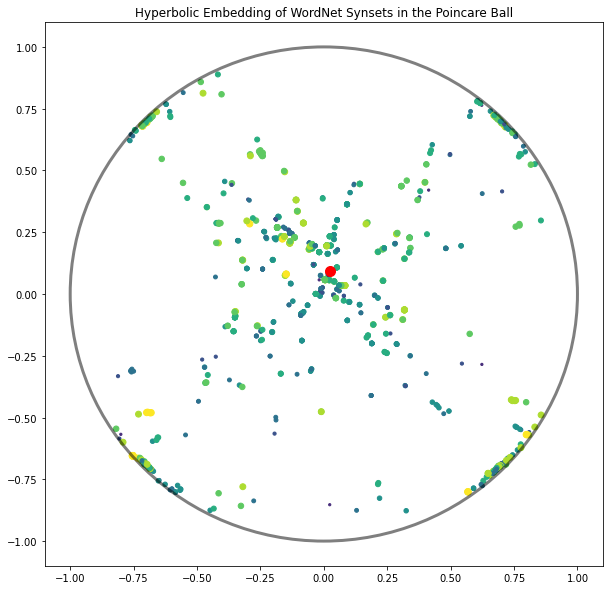

In [99]:
import matplotlib.pyplot as plt
import matplotlib.patches as pt
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib inline

def _get_index(df, word='placental.n.01'):
    return df.loc[word].ind

def plot_x(x):
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    circle = pt.Circle((0, 0), 1, facecolor='none', edgecolor=(0, 0, 0), linewidth=3, alpha=0.5)
    ax.add_patch(circle)
    levels = list(df.level)
    sc = plt.scatter(x[:,0], x[:,1], vmin=min(levels), vmax=max(levels), c=levels, s=[l*5 for l in levels])
    plac_index = _get_index(df, 'placental.n.01')
    plt.scatter(x[plac_index, 0], x[plac_index, 1], color='red', s=100)
    plt.title("Hyperbolic Embedding of WordNet Synsets in the Poincare Ball")
#     plt.colorbar(sc)
    plt.show()

    
# f = lambda t: plot_x(x = xts[t])
# interact(f,t = widgets.IntSlider(min = 0, max = len(xts)-1, step = 1, continuous_update = False));

plot_x(x.detach().numpy())
plt.show()

# Visualize the Embeddings Throughout the Optimization Process

In [12]:
import torch.optim as optim
from optimization import L

In [39]:
def proj(x, epsilon = 1e-6):
    """Rescale the point to ensure that it lies within the Poincare Ball."""
    norm_x = torch.linalg.norm(x, axis = 1, keepdims = True)
    return torch.where(norm_x >= 1, (x / (norm_x + epsilon)), x) # (x / norm_x) - epsilon  # Todo: bUG? ********

In [14]:
# issue in last term of denominators: nan

In [15]:
# x0 = x.detach()

In [16]:
torch.version.__version__

'1.7.1'

In [69]:
with torch.no_grad():
    x = proj(x)
    print(x.requires_grad)
    x.requires_grad = True

False


In [70]:
lr = 1e-5
epsilon = 1e-6
n_iter = 400
n_neg_samples = 10
custom_descent = False
optim = torch.optim.Adam([x], lr=lr)

for i in range(n_iter):
    Nu = generate_Nu(D,n_neg_samples)
#     import pdb; pdb.set_trace()
    
    loss = 0
    n_features = x.shape[-1]
    for (u_ind, v_inds) in D:
        u = x[u_ind,:].reshape(1,n_features)
        vs = x[v_inds,:].reshape(len(v_inds),n_features)
        # Numerator: Positive Pairs
        numerators = torch.log(torch.exp(-geom.d(u,vs,epsilon)))

        # Denominator: Negative Pairs
        vp_inds_lists = Nu[u_ind]
        vp_x = x[vp_inds_lists,:]
#         d = torch.tensor(x_tmp, requires_grad = True)
        
        denominators = torch.stack([torch.logsumexp(-geom.d(u,vi,epsilon),dim = 0) for vi in vp_x])
#         denominators = torch.stack([torch.sum(exp_d(u,vi)) for vi in vp_x])
        # Loss for this u: set of (u,[v1,v2,...,vn])
#         print(torch.isinf(denominators).any())
        L_u = torch.sum(numerators - denominators)
        
        # switch loss to -loss
        loss -= L_u  #?? ******
        
    loss /= len(D)
    optim.zero_grad()
    loss.backward()
    if custom_descent:
        with torch.no_grad():
            g_pb_inv = ((1 - torch.linalg.norm(x,axis = 1) ** 2) ** 2) / 4
            x.sub_(lr * g_pb_inv.unsqueeze(1) * x.grad)
            x.copy_(proj(x))
    else:
        optim.step()
# FIND NAN / INF explosions
#     with torch.no_grad():
#         norm_x = torch.linalg.norm(x, axis = 1, keepdims = True)
#         x = torch.where(norm_x >= 1, x / (norm_x + epsilon), x)
    if i % (n_iter//10) == 0:
        print(loss)

tensor(2.7505, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(2.6301, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(2.7114, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(2.6828, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(2.6240, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(2.7378, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(2.7291, dtype=torch.float64, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [71]:
loss

tensor(2.7664, dtype=torch.float64, grad_fn=<DivBackward0>)

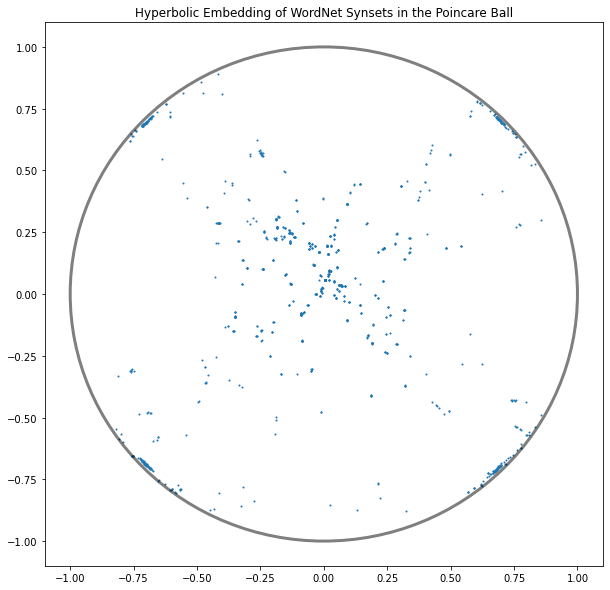

In [72]:
plot_x(x.detach().numpy())#,df)

In [73]:
indexes = torch.where(torch.linalg.norm(x, dim=1) < 0.03)
# indexes[0].tolist()
# type(indexes[0].tolist()[0])
type(df.iloc[0]['ind'])

numpy.int64

In [74]:
x.shape
print(x.shape, len(df))

torch.Size([1120, 2]) 1120


In [75]:
df["ind"].isin(indexes[0].tolist())

str_synset
aardvark.n.01             False
aardwolf.n.01             False
aberdeen_angus.n.01       False
abrocome.n.01             False
abyssinian.n.01           False
                          ...  
yorkshire_terrier.n.01    False
zebra.n.01                False
zebu.n.01                 False
zinjanthropus.n.01        False
zoril.n.01                False
Name: ind, Length: 1120, dtype: bool

In [76]:
df[df["ind"].isin(indexes[0].tolist())]

,ind,hyponyms,level,D,numeric_synset
str_synset,,,,,
eastern_chipmunk.n.01,313,None,3,False,None
edentate.n.01,319,"[anteater.n.02, armadillo.n.01, megatherian.n....",1,True,"[41, 58, 636, 676, 677, 916]"
equine.n.01,332,"[ass.n.03, hinny.n.01, horse.n.01, mule.n.01, ...",3,True,"[63, 471, 489, 667, 810, 1116]"
ground_sloth.n.01,436,None,3,False,None
hedgehog.n.02,467,None,2,False,None
hinny.n.01,471,None,4,False,None
insectivore.n.01,512,"[hedgehog.n.02, mole.n.06, otter_shrew.n.01, s...",1,True,"[467, 647, 714, 897, 994]"
mapinguari.n.01,618,None,3,False,None
megatherian.n.01,636,[ground_sloth.n.01],2,True,[436]


Hyponyms:
[Synset('aardvark.n.01'), Synset('aquatic_mammal.n.01'), Synset('bat.n.01'), Synset('buck.n.05'), Synset('bull.n.11'), Synset('carnivore.n.01'), Synset('cow.n.02'), Synset('digitigrade_mammal.n.01'), Synset('doe.n.02'), Synset('edentate.n.01'), Synset('fissipedia.n.01'), Synset('flying_lemur.n.01'), Synset('hyrax.n.01'), Synset('insectivore.n.01'), Synset('lagomorph.n.01'), Synset('livestock.n.01'), Synset('pachyderm.n.01'), Synset('pangolin.n.01'), Synset('plantigrade_mammal.n.01'), Synset('primate.n.02'), Synset('proboscidean.n.01'), Synset('rodent.n.01'), Synset('tree_shrew.n.01'), Synset('unguiculata.n.01'), Synset('unguiculate.n.01'), Synset('ungulata.n.01'), Synset('ungulate.n.01'), Synset('yearling.n.03')]

In [78]:
df.loc["placental.n.01"]

ind                                                             760
hyponyms          [aardvark.n.01, aquatic_mammal.n.01, bat.n.01,...
level                                                             0
D                                                              True
numeric_synset    [0, 52, 91, 170, 174, 198, 257, 284, 290, 319,...
Name: placental.n.01, dtype: object

In [29]:
df.loc["hedgehog.n.02"]

ind                 467
hyponyms           None
level                 2
D                 False
numeric_synset     None
Name: hedgehog.n.02, dtype: object

In [80]:
x[760]

tensor([0.0263, 0.0937], dtype=torch.float64, grad_fn=<SelectBackward>)

In [ ]:
plot_x(x.detach().numpy())#,df)

--------------
--------------

THE SCRAPS BELOW

In [ ]:
x[torch.linalg.norm(x,axis=1) >= 0.386]

In [ ]:
for i,xi in enumerate(x):
#     print(xi)
    if torch.linalg.norm(xi) >= 0.386:
        print(i)

In [ ]:
df

In [ ]:
plot_x(x.detach().numpy())
plt.show()

In [ ]:
torch.isnan(torch.sum(x.grad,axis = 1)).nonzero(as_tuple=True)[0]

In [ ]:
u_ind = 42
tons of v_inds

In [ ]:
x[42]

In [ ]:
Nu[42]

In [ ]:
torch.isnan(torch.sum(x1,axis = 1)).nonzero(as_tuple=True)[0]

In [ ]:
torch.isnan(torch.sum(x1,axis = 1)).nonzero(as_tuple=True)[0]

In [ ]:
x[63]

In [ ]:
x.grad[42]

In [ ]:
len(x)

In [ ]:
torch.where(torch.isnan(torch.sum(x,axis = 1)), torch.range(0,len(x)-1), 0*torch.range(0,len(x)-1))

In [ ]:
torch.range(0,len(x)-1)

In [ ]:
list(range(0,len(x)))

In [ ]:
x[149,:]

In [ ]:

nloss

In [ ]:
L(x,D,Nu)

In [ ]:
lr = 1e-5
g_pb_inv = ((1 - torch.linalg.norm(x,axis = 1)**2)**2)/4
x = proj(x - lr*g_pb_inv.unsqueeze(1)*x.grad)

In [ ]:
x

In [ ]:
L(x,D,Nu)

In [ ]:
g_pb_invz

In [ ]:
g_pb_inv.unsqueeze(1)*x.grad

In [ ]:
x

In [ ]:
loss

# Explicit Computation for one pass

In [ ]:
list(filter(lambda x: x[0] == 63, D))

In [ ]:
for i, di in enumerate(D):
    if di[0] == 63:
        print(i)

In [ ]:
len(D)

In [ ]:
torch.logsumexp()

In [ ]:
vi = vp_x0[0,:]

In [ ]:
vi

In [ ]:
u

In [ ]:
torch.log(torch.sum((torch.exp(-geom.d(u,vi)))))

In [ ]:
torch.logsumexp(-geom.d(u,vi),dim = 0)

In [ ]:
[torch.logsumexp(-geom.d(u,vi),dim = 0) for vi in vp_x0]

In [ ]:
torch.log(torch.exp(-geom.d(u,vs)))

In [ ]:
denominators = torch.stack([torch.logsumexp(-geom.d(u,vi),dim = 0) for vi in vp_x0])

In [ ]:
Nu = generate_Nu(D)

u_ind, v_inds = D[11]
print(u_ind)
print(v_inds)

u = x[u_ind,:].reshape(1,n_features)
print(u)

vs = x[v_inds,:].reshape(len(v_inds),n_features)
print(vs)

numerators = torch.log(torch.exp(-geom.d(u,vs)))
print(numerators)

vp_inds_lists = Nu[u_ind]
print(vp_inds_lists)

vp_x0 = x[vp_inds_lists,:]
denominators = torch.stack([torch.logsumexp(-geom.d(u,vi),dim = 0) for vi in vp_x0])

L_u = torch.sum(numerators / denominators)
print(L_u)

In [ ]:
x[63,:].grad

# 2. Initialize Problem

In [ ]:
scale = 0.1
n_points = df.shape[0]
x0 = scale * (1 - 2*np.random.rand(2 , n_points))

# 3. Optimize to Find Poincare Embeddings

In [ ]:
# Not yet completed
xts, losses = rgd(proj(x0), D = D, num_iter = 40)

In [ ]:
xf = xts[-1]

# 4. Visualization 

### 4.1 Visualize the Embeddings Throughout the Optimization Process

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as pt
from ipywidgets import interact
import ipywidgets as widgets

In [ ]:
def plot_x(x):
    fig, ax = plt.subplots(figsize=(10, 10))
    circle = pt.Circle((0, 0), 1, facecolor='none', edgecolor=(0, 0, 0), linewidth=3, alpha=0.5)
    ax.add_patch(circle)
    plt.scatter(x[0,:], x[1,:], s=1)
    plt.title("Hyperbolic Embedding of WordNet Synsets in the Poincare Ball")
    plt.show()

    
f = lambda t: plot_x(x = xts[t])
interact(f,t = widgets.IntSlider(min = 0, max = len(xts)-1, step = 1, continuous_update = False));

In [ ]:
plot_x(xts[-1])

### 4.2 Visualize Subtrees from WordNet with Networkx
TODO

In [ ]:
import networkx as nx
from matplotlib import cm

In [ ]:
# def display_subtrees_nx(synset_root):
#     """Display the synset subtrees beginning from a synset root."""
synset_root = wn.synset('antelope.n.01')
df = generate_synset_df(synset_root)
max_level = df.level.max()
D = generate_D(df)
dg = nx.DiGraph()
for (u_ind, v_inds) in D:
    dg.add_edges_from([(u_ind, v_ind) for v_ind in v_inds])

labels = {}    
color_map = []
for node in dg.nodes():
    labels[node] = df.iloc[node].name
    color_map.append(cm.coolwarm(float(df.level[node])/max_level))

fig = plt.figure(figsize = (15,15))
nx.draw(dg, with_labels=False, node_color=color_map)
labeled_nodes = nx.draw_networkx_labels(dg, pos = nx.spring_layout(dg), labels = labels)

# 5. Explore Embedding Performance

TODO

# 6. Additional Sanity Checks

### Test the partial derivative of the distance function with respect to u or v

In [ ]:
u = 1*(2-np.random.rand(2,1))
v = 1*(2-np.random.rand(2,1))

delta = 1E-8
# wrt u
print('u')
print(np.dot(np.ones((2,1)).T, dp(u, v)))
print((d(u+delta, v) - d(u, v))/delta)

# wrt v
print('v')
print(np.dot(np.ones((2,1)).T,dp(v,u)))
print((d(u, v+delta) - d(u, v))/delta)

### Test the Euclidean gradient of the loss function

TODO: Fix/Finish implementing the gradient

Currently the gradient is just a low-magnitude random vector, so these numbers won't be close

In [ ]:
mammal = wn.synset('mammal.n.01')
df = generate_synset_df(mammal)
scale = 0.5
n_points = df.shape[0]
x0 = scale * (1 - 2*np.random.rand(2 , n_points).astype(np.float64))
D = generate_D(df)
Nu = generate_Nu(D, Nu_n_samples=10)

dx0 = 1E-6
print('True Loss Slope: ' + str((L(x0 + dx0*np.ones_like(x0), D, Nu) - L(x0, D, Nu))/dx0))
print('grad_E Slope: ' + str(np.dot(np.ones((2,n_points)).flatten().T, grad_E(x0, D, Nu).flatten())))
# I need to fix the gradient step: I'm getting divide by zero / np.inf values out!
# For now I've replaced the gradient with random values to test this issue
# These will not equal each other!

TODO: Fix the gradient method so that I don't have any more np.infs!

In [ ]:
ge = grad_E(x0, D, Nu)
ge[ge == np.inf]